# Table of Contents
* [1. Test Case 3. Near Pedestal Diagnostic](#1.-Test-Case-3.-Near-Pedestal-Diagnostic)
	* [1.1 Plasma parameters](#1.1-Plasma-parameters)
	* [1.2 Detectors setup](#1.2-Detectors-setup)
	* [1.3 Results](#1.3-Results)


# 1. Test Case 3. Near Pedestal Diagnostic

## 1.1 Plasma parameters

In [1]:
# Some initial setups
from __future__ import print_function
import sys

import numpy as np
from scipy.integrate import trapz, cumtrapz
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import rcParams

from FPSDP.GeneralSettings.UnitSystem import cgs
import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
import FPSDP.Diagnostics.ECEI.ECEI2D.Reciprocity as rcp
from FPSDP.Diagnostics.ECEI.ECEI2D.Detector2D import GaussianAntenna
import FPSDP.Plasma.PlasmaCharacter as pc
from FPSDP.Diagnostics.ECEI.ECEI2D.Imaging import ECEImagingSystem
import ipyparallel as ipp


%matplotlib inline

rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 18

c = cgs['c']
keV = cgs['keV']
e = cgs['e']
me = cgs['m_e']
pi = np.pi
twopi = 2*np.pi

In [2]:
Te0 = 10*keV
ne0 = 4.5e13
#ne0 = 4e13
tp.set_parameter2D(Te_0=Te0, Te_shape='Hmode', ne_0=ne0, ne_shape='Hmode', 
                   R_0=200, a=75, DownLeft=(-30, 125), UpRight=(30, 280), NR=601, NZ=241)

In [3]:
tp.show_parameter2D()

R_0 : 200
a : 75
DownLeft : (-30, 125)
UpRight : (30, 280)
NR : 601
NZ : 241
ne_0 : 4.5e+13
Te_0 : 1.6022e-08
B_0 : 20000
ne_shape : Hmode
Te_shape : Hmode
dne_ne : 0.01
dte_te : 0.01
dB_B : 0
siny : {'y0': 0, 'k': 21, 'omega': 628000.0, 'x0': 220, 'dx': 5}
sinx : {'y0': 0, 'k': 6.28, 'omega': 628000.0, 'x0': 220, 'dy': 20}
timesteps : [0, 1, 2, 3]
dt : 2.5e-06


In [4]:
p2d_hmode = tp.create_profile2D()
print(p2d_hmode)

Electron Cyclotron Emission Imaging Plasma Profile:

Unit System:cgs
Length: centi-meter
Mass: gram
Time: second

Grid:2D Cartesian Grids
DownLeft :(-30, 125)
UpRight :(30, 280)
NR,ResR :(601, 0.2579034941763727)
NZ,ResZ :(241, 0.24896265560165975)

Physical Quantities:
Equilibrium:
    Electron density: ne0 (max: 4.5e+13, min:4.5e+03 cm^-3)
    Electron temperature: Te0 (max:10.0, min:1e-09 keV)
    Magnetic field: B0 (max:3.2e+04, min:1.43e+04 Gauss)
Fluctuation:




C:\Users\lei\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


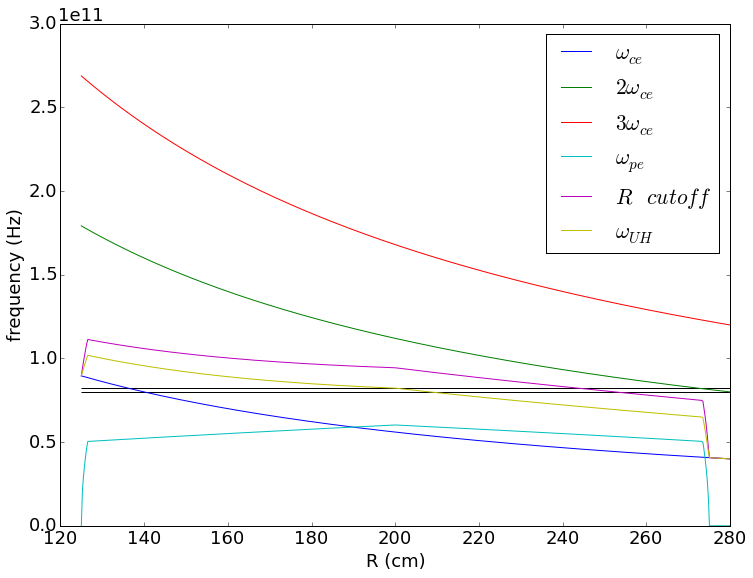

In [5]:
pcpr_hmode = pc.PlasmaCharProfile(p2d_hmode)
R1D = p2d_hmode.grid.R1D
mid_ZHmode = p2d_hmode.grid.NZ/2
plt.figure()
plt.plot(R1D, pcpr_hmode.omega_ce[mid_ZHmode, :]/twopi, label='$\omega_{ce}$')
plt.plot(R1D, 2*pcpr_hmode.omega_ce[mid_ZHmode, :]/twopi, label='$2\omega_{ce}$')
plt.plot(R1D, 3*pcpr_hmode.omega_ce[mid_ZHmode, :]/twopi, label='$3\omega_{ce}$')
plt.plot(R1D, pcpr_hmode.omega_pe[mid_ZHmode, :]/twopi, label='$\omega_{pe}$')
plt.plot(R1D, pcpr_hmode.omega_R[mid_ZHmode, :]/twopi, label='$R \; cutoff$')
plt.plot(R1D, pcpr_hmode.omega_UH[mid_ZHmode, :]/twopi, label='$\omega_{UH}$')
plt.hlines(y=[0.8e11, 0.824e11], xmin=np.min(R1D), xmax=np.max(R1D))
plt.legend(loc='best')
plt.ylabel('frequency (Hz)')
plt.xlabel('R (cm)')

## 1.2 Detectors setup

In [6]:
omega_array = twopi*np.linspace(0.8e11, 0.824e11, 8)
k_array = omega_array/c
x_array = np.linspace(280, 273.5, 8)
wave_length_array = twopi/k_array

In [7]:
detector_array = [GaussianAntenna(omega_list=[omega], k_list=[k_array[i]], 
                                  power_list=[1], waist_x=x_array[i], 
                                  waist_y=0, w_0y=2*wave_length_array[i], tilt_h=0) \
                  for i, omega in enumerate(omega_array)]

In [8]:
client = ipp.Client()
ecei_hmode = ECEImagingSystem(plasma=p2d_hmode, detectors=detector_array, 
                              polarization='X', max_harmonic=2, max_power=2, 
                              weakly_relativistic=True, isotropic=True,
                              parallel=True, client=client)

In [9]:
X1D = np.linspace(280, 255, 100)
Y1D = np.linspace(-20, 20, 65)
Z1D = np.linspace(-20, 20, 65)

In [10]:
ecei_hmode.set_coords([Z1D, Y1D, X1D])

In [11]:
ecei_hmode.auto_adjust_mesh()

Parallel run with 8 channels on 8 engines.
channel #0 on engine #0.
channel #1 on engine #1.
channel #2 on engine #2.
channel #3 on engine #3.
channel #4 on engine #4.
channel #5 on engine #5.
channel #6 on engine #6.
channel #7 on engine #7.
Walltime: 17.5s


## 1.3 Results

In [12]:
ecei_hmode.view_points

((0.0, 0.0, 274.19191919191917),
 (0.0, 0.0, 274.44444444444446),
 (0.0, 0.0, 274.44444444444446),
 (0.0, 0.0, 274.44444444444446),
 (0.0, 0.0, 274.19191919191917),
 (0.0, 0.0, 270.90909090909093),
 (0.0, 0.0, 269.64646464646466),
 (0.0, 0.0, 268.63636363636363))

In [13]:
ecei_hmode.diagnose()

Parallel run for 8 channels on 8 engines.
Channel #0 on engine #0
Channel #1 on engine #1
Channel #2 on engine #2
Channel #3 on engine #3
Channel #4 on engine #4
Channel #5 on engine #5
Channel #6 on engine #6
Channel #7 on engine #7
Walltime: 17.18s


array([  5.59330230e-09,   6.48081793e-09,   6.10556584e-09,
         5.83215037e-09,   7.60090830e-09,   1.20566161e-08,
         1.27578176e-08,   1.29396749e-08])

In [14]:
Te_measured = ecei_hmode.Te/keV
print('measured Te: {0}'.format(Te_measured))

measured Te: [ 3.49101379  4.0449494   3.81073888  3.64008886  4.74404463  7.52503814
  7.96268732  8.07619202]


In [15]:
y2d, x2d = np.meshgrid(Y1D, X1D, indexing='ij')
pcpr_hmode.set_coords([y2d, x2d])
cold_res_locs = pcpr_hmode.find_cold_ECE_res(omega_array)
print('Cold resonance locations:{0}'.format(cold_res_locs))

Cold resonance locations:[ 279.92646692  278.73188211  277.54752841  276.37315664  275.20862257
  274.05395446  272.90883874  271.77332706]


In [16]:
Te_real = p2d_hmode.get_Te0([[0 for i in xrange(len(cold_res_locs))],cold_res_locs])/keV
print('Real Te at cold resonance location: {0}'. format(Te_real))

Real Te at cold resonance location: [  1.00000000e-09   1.00000000e-09   1.00000000e-09   1.00000000e-09
   1.00000000e-09   5.04557619e+00   8.01608602e+00   8.04698430e+00]


In [17]:
vs = ecei_hmode.view_spots
X1Ds = ecei_hmode.X1Ds
Y1Ds = ecei_hmode.Y1Ds

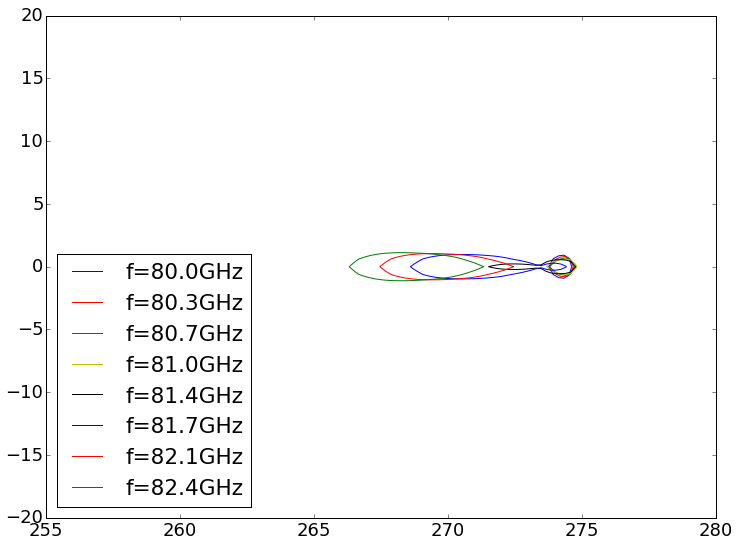

In [31]:
colors = ['b', 'r', 'g', 'y', 'k']
lines = []
labels = []
nd = len(omega_array)
for i in xrange(nd):
    cs = plt.contour(X1Ds[i], Y1Ds[i], vs[i], [0.368], colors=colors[i%5])
    lines.append(cs.collections[0])
    labels.append('f={0:.3}GHz'.format(omega_array[i]*1e-9/twopi))

plt.legend(lines, labels, loc='lower left')

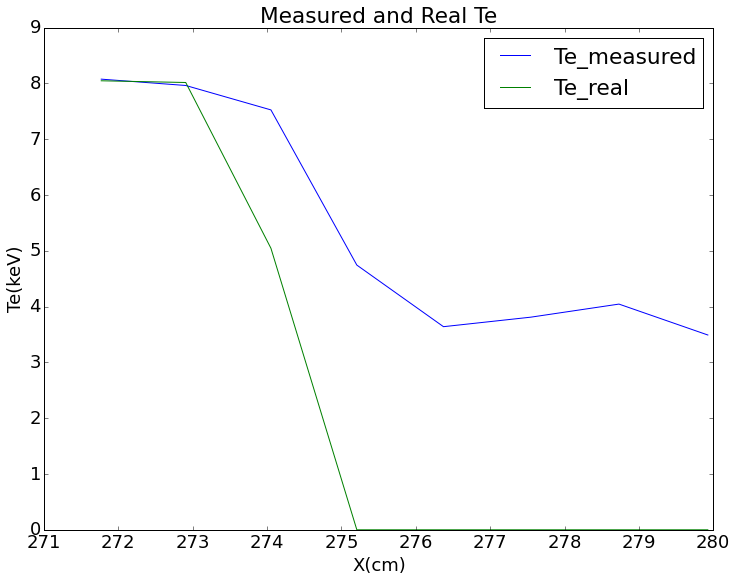

In [19]:
plt.plot(cold_res_locs, Te_measured, label='Te_measured')
plt.plot(cold_res_locs, Te_real, label='Te_real')
plt.xlabel('X(cm)')
plt.ylabel('Te(keV)')
plt.title('Measured and Real Te')
plt.legend(loc='best')